In [1]:
from google.colab import drive

drive.mount('/content/Drive')

Mounted at /content/Drive


In [2]:
from pathlib import Path
from zipfile import ZipFile

data_drive = Path('/content/Drive/MyDrive/Colab Notebooks/datasets')

zip_ref = ZipFile(data_drive/'chest_xrays.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

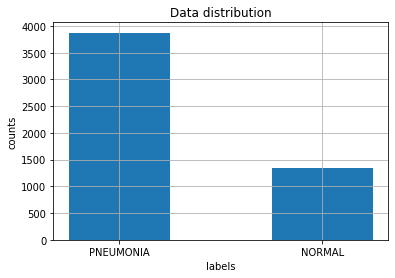

In [3]:
import os
import matplotlib.pyplot as plt

data_dir = Path('/tmp/chest_xrays')
POS_LABEL = 'PNEUMONIA'
NEG_LABEL = 'NORMAL'

train_dir = data_dir / 'train'
train_pos_filenames = [ train_dir / POS_LABEL / filename for filename in os.listdir(train_dir/POS_LABEL) ]
train_neg_filenames = [ train_dir / NEG_LABEL / filename for filename in os.listdir(train_dir/NEG_LABEL) ]

valid_dir = data_dir / 'val'
valid_pos_filenames = [ valid_dir / POS_LABEL / filename for filename in os.listdir(valid_dir/POS_LABEL) ]
valid_neg_filenames = [ valid_dir / NEG_LABEL / filename for filename in os.listdir(valid_dir/NEG_LABEL) ]

plt.bar([POS_LABEL, NEG_LABEL], [len(train_pos_filenames), len(train_neg_filenames)], width=0.5)
plt.xlabel('labels')
plt.ylabel('counts')
plt.title('Data distribution')
plt.grid(True)
plt.show()

In [4]:
print('total amount of training data: ', len(train_pos_filenames + train_neg_filenames))
print('total amount of validation data: ', len(valid_pos_filenames + valid_neg_filenames))

total amount of training data:  5216
total amount of validation data:  16


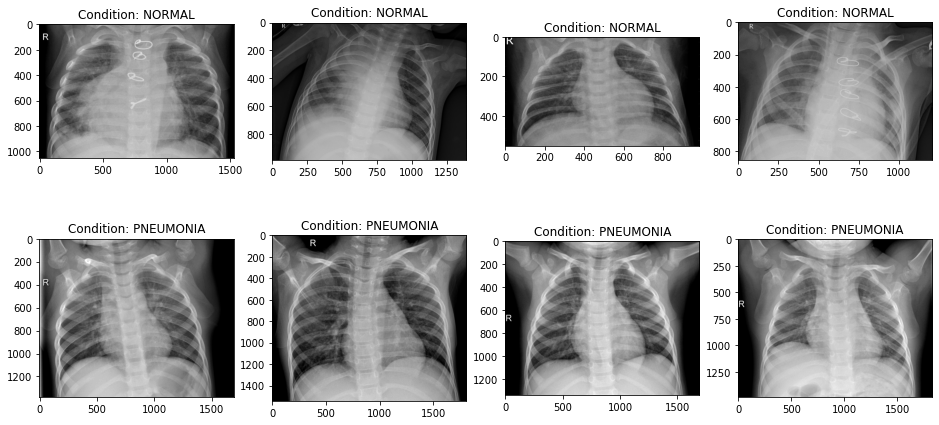

In [6]:
import utils

utils.display_chest_xrays(train_pos_filenames, train_neg_filenames)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1/255.).flow_from_directory(train_dir,
                                                                   target_size=(300, 300),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=True)

valid_gen = ImageDataGenerator(rescale=1/255.).flow_from_directory(valid_dir,
                                                                   target_size=(300, 300),
                                                                   batch_size=16,
                                                                   class_mode='binary',
                                                                   shuffle=True)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### Training

In [17]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 33, 33, 128)      

In [11]:
pos_freq, neg_freq = utils.compute_class_freqs(train_gen.labels)

pos_weights = pos_freq / (pos_freq + neg_freq)
neg_weights = neg_freq / (pos_freq + neg_freq)

weighted_loss = utils.get_weighted_loss([pos_weights], [neg_weights])

In [16]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(0.0001),
              metrics=['acc'],
              loss=weighted_loss)

history = model.fit_generator(train_gen,
                              epochs=5,
                              steps_per_epoch=163,
                              validation_data=valid_gen)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
163/163 [==============================] - 63s 368ms/step - loss: 0.1824 - acc: 0.7769 - val_loss: 0.1800 - val_acc: 0.6250
Epoch 2/5
163/163 [==============================] - 59s 360ms/step - loss: 0.0594 - acc: 0.9384 - val_loss: 0.1324 - val_acc: 0.7500
Epoch 3/5
163/163 [==============================] - 59s 362ms/step - loss: 0.0428 - acc: 0.9613 - val_loss: 0.3486 - val_acc: 0.6250
Epoch 4/5
163/163 [==============================] - 59s 361ms/step - loss: 0.0394 - acc: 0.9579 - val_loss: 0.3133 - val_acc: 0.6250
Epoch 5/5
163/163 [==============================] - 59s 363ms/step - loss: 0.0302 - acc: 0.9711 - val_loss: 0.1891 - val_acc: 0.6875


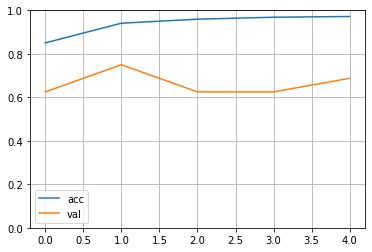

In [19]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
epochs = range(len(history.epoch))

plt.plot(epochs, accuracy, label='acc')
plt.plot(epochs, val_accuracy, label='val')

plt.grid(True)
plt.ylim([0, 1.])
plt.legend()
plt.show()